In [95]:
import numpy as np
import optax
import jax
import equinox as eqx
import matplotlib.pyplot as plt

from cc.examples.linear_model import make_linear_model
from cc.env import make_env
from cc.env.wrappers import AddRefSignalRewardFnWrapper, ReplacePhysicsByModelWrapper
from cc.train import TrainingOptionsController, make_dataloader, ModelControllerTrainer, UnsupervisedDataset, Tracker
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect import collect_exhaust_source, random_steps_source

In [2]:
A= np.array([[-0.33759607 ,  0.08608127,  0.57494069],
    [ 0.61775183, -1.09155238,  0.54087305],
    [-0.01583903, -0.04649417, -1.38709049]])
B= np.array([[1.13170034],
            [-0.  ],
            [0.93708961]])
C= np.array([[-0.82243542,  1.67057984,  0.42432609]])
D= np.array([[0.0]])

In [22]:
env = make_env('two_segments_v2')
m = make_linear_model(env.action_spec(), env.observation_spec(), env.control_timestep(), 3)
m = eqx.tree_at(lambda m: (m.A, m.B, m.C, m.D), m, (A, B, C, D))
env = ReplacePhysicsByModelWrapper(env, m)

In [39]:
source = random_steps_source(env, seeds=list(range(30)), max_abs_amplitude=0.5)
env_w_source = AddRefSignalRewardFnWrapper(env, source)

In [84]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep(),
    5,
    f_depth=0
)

In [86]:
controller_dataloader = make_dataloader(
    UnsupervisedDataset(source.get_references_for_optimisation()),
    jax.random.PRNGKey(1,),
    n_minibatches=5,
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))

controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, 
)

controller_trainer = ModelControllerTrainer(
    m, controller, controller_train_options=controller_train_options, 
    trackers=[Tracker("loss")]
)

This model has been registered with model name `model0`.
                    When using multiple models individual model names have to
                    be provided by passing a dictionary in the `model` argument


In [87]:
controller_trainer.run(2500)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [88]:
fitted_controller = controller_trainer.trackers[0].best_model_or_controller()
controller_trainer.trackers[0].best_metric()

0.39480454

In [96]:
eval_source = random_steps_source(env, list(range(6)))

# returns a tuple
controller_performance_sample, loop_results = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)

Reference Iterator:   0%|          | 0/6 [00:00<?, ?it/s]

In [97]:
loop_results

{'env_reset_duration_sec': array([0.00105786, 0.00034213, 0.00066185, 0.00032806, 0.00071502,
        0.00037408]),
 'env_step_duration_sec': array([0.00048498, 0.00047793, 0.00047915, 0.00047459, 0.00047908,
        0.00048799]),
 'episode_length': array([1000, 1000, 1000, 1000, 1000, 1000]),
 'episode_return': array([ -757.137   , -2142.5518  ,   -73.77877 ,   -10.77137 ,
        -1747.4124  ,    -6.575613], dtype=float32),
 'episodes': array([1, 1, 1, 1, 1, 1]),
 'select_action_duration_sec': array([0.00038519, 0.0003781 , 0.00037986, 0.00037607, 0.00037849,
        0.00038505]),
 'steps': array([1000, 1000, 1000, 1000, 1000, 1000]),
 'steps_per_second': array([1131.4303626 , 1151.1147082 , 1146.58117228, 1158.42798851,
        1148.50387681, 1128.52676048])}

In [98]:
np.mean(-controller_performance_sample.rew)

0.7897087

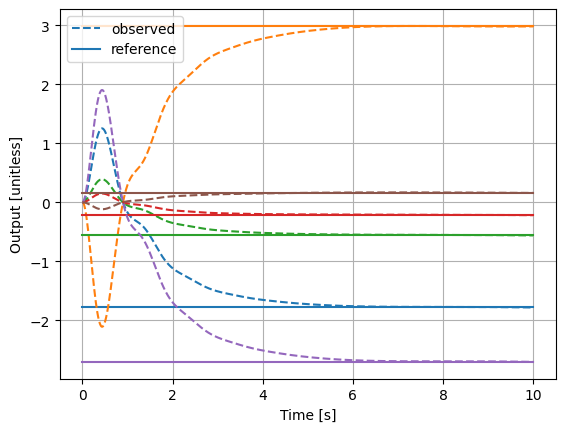

In [103]:
ts = np.arange(10.01, step=0.01)
for i in range(6):
    label_obs = "observed" if i == 0 else None
    label_ref = "reference" if i == 0 else None
    color = f"C{i}"
    plt.plot(ts, controller_performance_sample.obs["obs"]["xpos_of_segment_end"][i], label=label_obs, color=color, linestyle="dashed")
    plt.plot(ts, controller_performance_sample.obs["ref"]["xpos_of_segment_end"][i], label=label_ref, color=color)

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Output [unitless]")
plt.savefig("example_perf.png", dpi=300)